## Overview

This implementation includes:
- **WindyGridworldEnv**: A custom environment simulating an agent navigating a grid with wind effects
- **SARSA**: On-policy temporal difference learning with exploration rate decay
- **Visualization**: Value function heatmaps, policy arrows, and learning curves
- **Variations**: Support for king's moves and stochastic wind

## Parameters

### SARSA Algorithm

| Parameter | Description | Default |
|-----------|-------------|---------|
| `num_episodes` | Number of training episodes | 500 |
| `eps0` | Initial exploration rate | 0.5 |
| `alpha` | Learning rate | 0.5 |

### WindyGridworldEnv

| Parameter | Description | Default |
|-----------|-------------|---------|
| `king` | Include diagonal king moves | False |
| `stochastic` | Add randomness to wind | False |
| `stop` | Include do-nothing action | False |

### SARSA (State-Action-Reward-State-Action)

SARSA is an on-policy temporal difference learning algorithm that updates Q-values based on the action actually taken:

$$Q(s, a) \leftarrow Q(s, a) + \alpha [r + \gamma Q(s', a') - Q(s, a)]$$

Key features:
- **On-policy**: Learns the value of the policy being followed
- **Exploration decay**: Epsilon decreases as $\epsilon_t = \frac{\epsilon_0}{t+1}$
- **Epsilon-greedy**: Balances exploration (random actions) with exploitation (best actions)

### Environment

The Windy Gridworld is a 10×7 grid where:
- **Agent** starts at position (0, 3)
- **Goal** is at position (7, 3)
- **Wind** pushes the agent upward with varying strength per column
- **Reward**: -1 per step (incentivizes shortest path)

Wind strength per column: `[0, 0, 0, 1, 1, 1, 2, 2, 1, 0]`

## References

- Sutton, R. S., & Barto, A. G. (2018). *Reinforcement Learning: An Introduction* (2nd ed.)
  - Example 6.5: Windy Gridworld
  - Exercise 6.9: Windy Gridworld with King's Moves
  - Exercise 6.10: Windy Gridworld with Stochastic Wind

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [2]:
class WindyGridworldEnv:
    """Windy Gridworld environment from Sutton & Barto Example 6.5.
    
    Supports variations:
    - king=True: Add diagonal moves (Exercise 6.9)
    - stochastic=True: Add stochastic wind (Exercise 6.10)
    - stop=True: Add stop action
    """
    
    size = (10, 7)
    start = (0, 3)
    goal = (7, 3)
    wind = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]
    
    # Action definitions
    pawn_actions = [(0, +1), (+1, 0), (0, -1), (-1, 0)]  # up, right, down, left
    king_actions = [(+1, +1), (+1, -1), (-1, -1), (-1, +1)]  # diagonals
    stop_action = [(0, 0)]
    
    observation_space = gym.spaces.MultiDiscrete(size)
    reward_range = (-1, -1)

    def __init__(self, king=False, stochastic=False, stop=False):
        """Initialize the environment.
        
        Args:
            king: If True, include diagonal king moves
            stochastic: If True, add randomness to wind
            stop: If True, include a do-nothing action
        """
        self.king = king
        self.stochastic = stochastic
        self.stop = stop
        
        # Build action set
        self.actions = self.pawn_actions.copy()
        if self.king:
            self.actions += self.king_actions
        if self.stop:
            self.actions += self.stop_action
        
        self.action_space = gym.spaces.Discrete(len(self.actions))
        self.position = None
        self.arrow = None
        self.ax = None

    def step(self, action):
        """Execute one step in the environment.
        
        Returns:
            position, reward, done, info
        """
        assert self.action_space.contains(action)
        
        # Calculate new position from action
        delta = self.actions[action]
        new_position = self.position + np.array(delta)
        
        # Apply wind effect
        wind = self.wind[self.position[0]]
        if self.stochastic and wind > 0:
            wind += np.random.choice([-1, 0, +1])
        new_position[1] += wind
        
        # Clip to grid boundaries
        new_position = np.clip(new_position, 0, self.observation_space.nvec - 1)
        
        # Store for rendering and update position
        self.arrow = new_position - self.position
        self.position = new_position
        
        # Check terminal condition
        done = (new_position == self.goal).all()
        reward = -1
        
        assert self.observation_space.contains(new_position)
        return new_position, reward, done, {}

    def reset(self):
        """Reset to start state."""
        self.position = np.array(self.start)
        self.arrow = np.array((0, 0))
        self.ax = None
        return self.position

    def render(self, mode='human'):
        """Render the environment."""
        if self.ax is None:
            fig = plt.figure()
            self.ax = fig.gca()
            
            # Background colored by wind strength
            wind_map = np.vstack([self.wind] * self.size[1])
            self.ax.imshow(wind_map, aspect='equal', origin='lower', cmap='Greens')
            
            # Annotations
            self.ax.annotate("G", self.goal, size=25, color='gray', ha='center', va='center')
            self.ax.annotate("S", self.start, size=25, color='gray', ha='center', va='center')
            
            # Ticks showing wind strength
            self.ax.set_xticks(np.arange(len(self.wind)))
            self.ax.set_xticklabels(self.wind)
            self.ax.set_yticks([])
            
            # Grid lines
            self.ax.set_xticks(np.arange(-0.5, self.size[0]), minor=True)
            self.ax.set_yticks(np.arange(-0.5, self.size[1]), minor=True)
            self.ax.grid(which='minor', color='black', linewidth=0.20)
            self.ax.tick_params(which='both', length=0)
            self.ax.set_frame_on(True)
        
        # Draw movement arrow or circle
        if (self.arrow == 0).all():
            patch = mpatches.Circle(self.position, radius=0.05, color='black', zorder=1)
        else:
            patch = mpatches.FancyArrow(
                *(self.position - self.arrow), *self.arrow,
                color='black', zorder=2, fill=True, width=0.05,
                head_width=0.25, length_includes_head=True
            )
        self.ax.add_patch(patch)

In [3]:
def sarsa(env, num_episodes, eps0=0.5, alpha=0.5):
    """On-policy SARSA algorithm with exploration rate decay.
    
    Args:
        env: Environment instance
        num_episodes: Number of episodes to train
        eps0: Initial exploration rate
        alpha: Learning rate
        
    Returns:
        q: Action-value function
        policy: Learned policy
        history: Episode lengths
    """
    n_actions = env.action_space.n
    n_states = np.ravel_multi_index(
        env.observation_space.nvec - 1, env.observation_space.nvec
    ) + 1
    
    # Initialize Q-values and policy
    q = np.zeros((n_states, n_actions), dtype=np.float32)
    policy = np.ones((n_states, n_actions), dtype=np.float32) / n_actions
    
    history = []
    
    for episode in range(num_episodes):
        state = env.reset()
        state_idx = np.ravel_multi_index(state, env.observation_space.nvec)
        action = np.random.choice(n_actions, p=policy[state_idx])
        
        steps = 0
        done = False
        
        while not done:
            next_state, reward, done, _ = env.step(action)
            next_state_idx = np.ravel_multi_index(next_state, env.observation_space.nvec)
            next_action = np.random.choice(n_actions, p=policy[next_state_idx])
            
            # Q-learning update
            q[state_idx, action] += alpha * (
                reward + q[next_state_idx, next_action] - q[state_idx, action]
            )
            
            # Epsilon-greedy policy update with exploration decay
            eps = eps0 / (episode + 1)
            policy[state_idx, :] = eps / n_actions
            policy[state_idx, np.argmax(q[state_idx])] += 1 - eps
            
            # Transition to next state-action pair
            state_idx = next_state_idx
            action = next_action
            steps += 1
        
        history.append(steps)
    
    return q, policy, history



In [4]:
def run_episode(env, policy, render=True):
    """Execute one episode following the given policy.
    
    Args:
        env: Environment instance
        policy: Policy to follow (n_states x n_actions)
        render: Whether to render the episode
        
    Returns:
        List of rewards collected
    """
    state = env.reset()
    if render:
        env.render()
    
    rewards = []
    done = False
    
    while not done:
        state_idx = np.ravel_multi_index(state, env.observation_space.nvec)
        action = np.argmax(policy[state_idx])
        state, reward, done, _ = env.step(action)
        rewards.append(reward)
        
        if render:
            env.render()
    
    if render:
        plt.show()
    
    return rewards


In [5]:
def plot_value_and_policy(env, q, policy):
    """Plot the learned value function and policy as a heatmap with arrows."""
    fig = plt.figure(figsize=(10, 8))
    ax = fig.gca()
    ax.set_title("Optimal Value Function and Policy")
    
    # Compute value function from Q-values
    q_copy = np.copy(q)
    unvisited = np.where(q_copy == 0)
    q_copy[unvisited] = -np.inf
    v = np.max(q_copy, axis=1).reshape(env.observation_space.nvec)
    
    # Plot value heatmap
    im = ax.imshow(v.T, origin='lower', cmap='viridis')
    plt.colorbar(im, ax=ax, label='State Value')
    
    # Plot policy arrows
    best_actions = np.argmax(policy, axis=1)
    arrows = np.array([env.actions[a] for a in best_actions])
    arrows[unvisited[0], :] = 0
    arrows = arrows.reshape([*env.observation_space.nvec, 2])
    
    xr = np.arange(env.observation_space.nvec[0])
    yr = np.arange(env.observation_space.nvec[1])
    ax.quiver(xr, yr, arrows[:, :, 0].T, arrows[:, :, 1].T, pivot='mid', scale=15)
    
    return fig

In [6]:
def plot_learning_curve(history):
    """Plot episode length over training."""
    fig = plt.figure(figsize=(10, 6))
    timesteps = np.cumsum([0] + history)
    episodes = np.arange(len(timesteps))
    
    plt.plot(timesteps, episodes, color='red', linewidth=2)
    plt.xlabel("Time steps")
    plt.ylabel("Episodes")
    plt.title("Learning Progress: SARSA")
    plt.grid(True, alpha=0.3)
    
    return fig

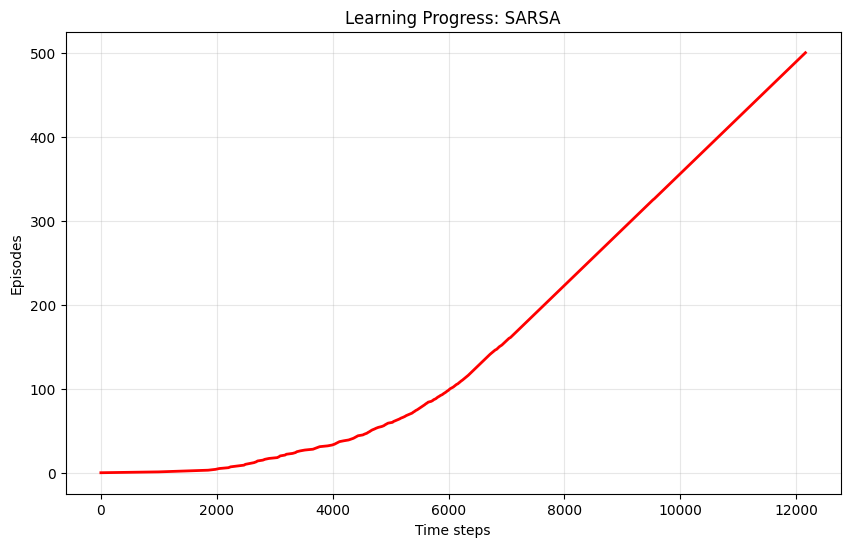

In [7]:
# Create environment and train on basic windy gridworld
env = WindyGridworldEnv()
q, policy, history = sarsa(env, num_episodes=500, eps0=0.5, alpha=0.5)

# Plot learning curve
plot_learning_curve(history)
plt.show()

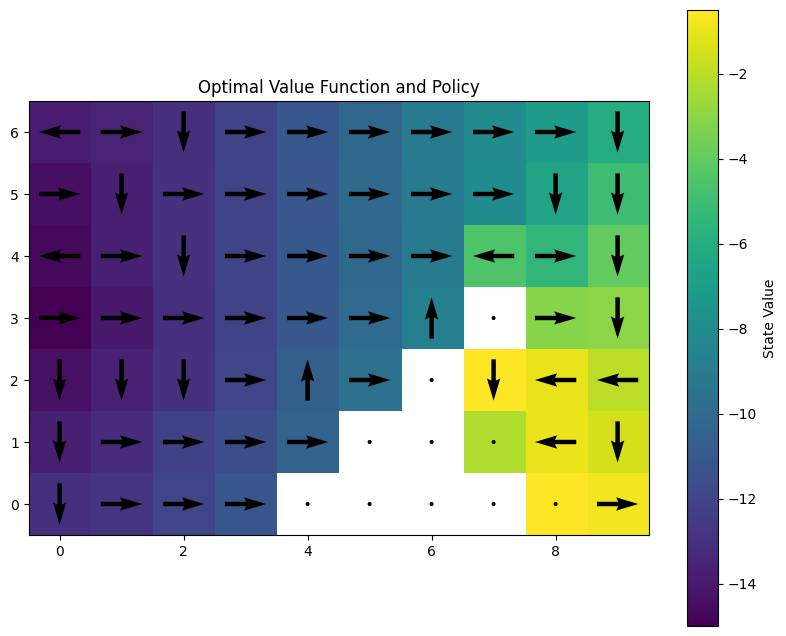

In [8]:
# Visualize results
plot_value_and_policy(env, q, policy)
plt.show()

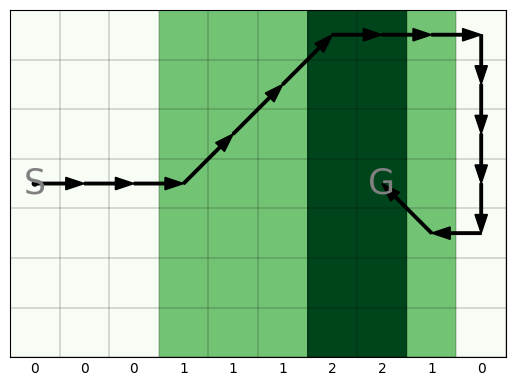

Episode length: 15


In [9]:
# Run learned policy
rewards = run_episode(env, policy, render=True)
print(f"Episode length: {len(rewards)}")

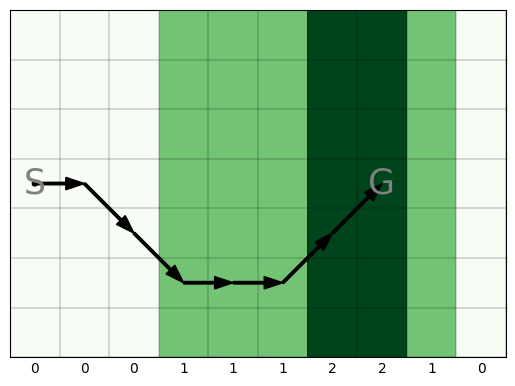

Episode length: 7


In [10]:
# With King's Moves
 
env = WindyGridworldEnv(king=True)
q, policy, history = sarsa(env, num_episodes=500, eps0=0.5, alpha=0.5)
print(f"Episode length: {len(run_episode(env, policy, render=True))}")

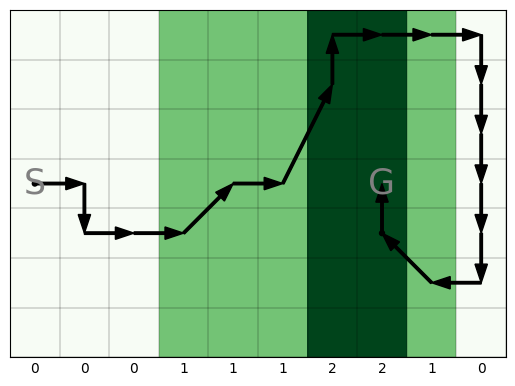

Episode length: 20


In [11]:
### With Stochastic Wind
env = WindyGridworldEnv(stochastic=True)
q, policy, history = sarsa(env, num_episodes=500, eps0=0.5, alpha=0.5) 
print(f"Episode length: {len(run_episode(env, policy, render=True))}")